# Setup

## Librerías, modulos y configuración de la notebook 

In [1]:
#### Librerías y modulos ####
import pandas as pd
import numpy as np
import seaborn as sns
import os,json
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [2]:
#### Configuraciones de la notebook ####
#pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [3]:
#### Parametros de la notebook ####
path_save = '../datos/'
# actualizado al 04/19
dolar_blue = 197
dolar_oficial = 119.28

## Load data

In [4]:
# Upload del pickle generado en la notebook "make_data"
df = pd.read_pickle('{}df_meli_2022-04-21.pkl'.format(path_save))

In [5]:
df.shape

(832016, 42)

# Data Cleaning/Preprocessing 

### *Eliminar nulos*

In [6]:
old_shape = df.shape[0]
df = df.dropna(subset=['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a'])
print(f'Hey! {old_shape - df.shape[0]} were removed due to null values')
old_shape = df.shape[0]

Hey! 1011 were removed due to null values


### *Eliminar duplicados*

In [7]:
# Tratamiento de la feautre "runtime"
df['runtime'] = pd.to_datetime(df.runtime.apply(lambda x: str(x)[:19]))
df = df.sort_values(['runtime'])
# Ahora si, teniendo el df ordenado, eliminamos los duplicados, quedandonos con el registro más reciente (la última ocurrencia)
df.drop_duplicates(subset=['car_id'], keep='last', inplace=True)

In [8]:
df.shape

(129823, 42)

### *Eliminar 11111 & 999999*

**Dropeamos valores como 111111 o 999999 (ya sean outliers o no)** --> ESTO HAY QUE SUMARLO AL PROCESAMIENTO DE LAS SIMULACIONES !!! <br> 
* Pueden existir casos donde estos valores extraños no sean outliers, por lo tanto no los vamos a conseguir limpiar cuando dropiemos outliers. Es por eso que desarrollamos el siguiente metodo
* Es clave hacerlo en este momento sobre "price_amount" y no luego sobre "price_meli_ok" ya que hay casos en los que el price simbol es USD y luego cuando lo multiplicamos por el TC para pasar a "price_meli_ok" dejan de cumplir estas condiciones de ser 111111 o 999999 y les perdemos el rastro

In [9]:
df['price_amount'] = df.price_amount.astype('int')

In [10]:
m1 = df.price_amount == 1111
m2 = df.price_amount == 11111
m3 = df.price_amount == 111111
m4 = df.price_amount == 1111111
m5 = df.price_amount == 11111111
m6 = df.price_amount == 111111111

len(df[m1 | m2 | m3 | m4 | m5 | m6])

42

In [11]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
3858,11111111
153336,11111111
110159,111111111
73622,1111111
29468,111111111


In [12]:
df.shape

(129823, 42)

In [13]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6)]

In [14]:
df.shape

(129781, 42)

*Ahora lo mismo pero para los casos 999999*

In [15]:
m1 = df.price_amount == 9999
m2 = df.price_amount == 99999
m3 = df.price_amount == 999999
m4 = df.price_amount == 9999999
m5 = df.price_amount == 99999999

len(df[m1 | m2 | m3 | m4 | m5])

87

In [16]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6][['price_amount']].head()

,price_amount
5973,99999999
61195,9999999
75290,999999
42914,999999
31525,9999999


In [17]:
df.shape

(129781, 42)

In [18]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [19]:
df.shape

(129694, 42)

*Ahora lo mismo para kms*

In [20]:
df['car_kms'] = df.car_kms.astype('int')

In [21]:
df[df.car_kms > 0]['car_kms'].min()

1

In [22]:
m1 = df.car_kms == 1
m2 = df.car_kms == 11
m3 = df.car_kms == 111
m4 = df.car_kms == 1111
m5 = df.car_kms == 11111
m6 = df.car_kms == 111111
m7 = df.car_kms == 1111111
m8 = df.car_kms == 11111111

len(df[ m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8])

806

In [23]:
# observamos
df[m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8][['car_kms']].head()

,car_kms
2799,1111
1177,111111
7810,11111
8492,11111
109356,11111


In [24]:
df.shape

(129694, 42)

In [25]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5 | m6 | m7 | m8)]

In [26]:
df.shape

(128888, 42)

*Lo mismo pero para los valores 99999*

In [27]:
m1 = df.car_kms == 999
m2 = df.car_kms == 9999
m3 = df.car_kms == 99999
m4 = df.car_kms == 999999
m5 = df.car_kms == 9999999

len(df[m1 | m2 | m3 | m4 | m5])

77

In [28]:
# observamos
df[m1 | m2 | m3 | m4 | m5][['car_kms']].head()

,car_kms
150229,99999
149711,999
17358,999999
51929,999999
62354,999999


In [29]:
df.shape

(128888, 42)

In [30]:
# dropeamos
df = df[~(m1 | m2 | m3 | m4 | m5)]

In [31]:
df.shape

(128811, 42)

In [32]:
# checkpoint
df.to_csv('{}df_checkpoint_1.pkl'.format(path_save))

In [33]:
df = pd.read_csv('{}df_checkpoint_1.pkl'.format(path_save))
df.shape

(128811, 43)

### *Precio final*

In [34]:
#Dropeamos los precios en dolares** --> Al final no lo hicimos
#Representan un 14% de la base !!! Caía mucho el test sin estos casos
# observamos su volumen
mask = df.price_symbol == 'U$S'
display(df[mask].shape)
display(round(df[mask].shape[0]/len(df),2))
# dropeamos
df.drop(list(df[mask].index),axis=0,inplace=True)
display(df.shape)

(14614, 43)

0.11

(114197, 43)

In [35]:
df.rename(columns={'price_amount':'price_meli_ok'},inplace=True)

In [36]:
# # Construcción del precio final
# blue= dolar_blue
# oficial= dolar_oficial
# col1 = 'price_symbol'
# col2 = 'car_kms'
# conditions = [df[col1]!='U$S', (df[col1]=='U$S') & (df[col2]==0), (df[col1]=='U$S') & (df[col2]!=0)]
# choices = [df.price_amount, df['price_amount']*oficial, df['price_amount']*blue]

# df['price_meli_ok'] = np.select(conditions, choices, default=np.nan)

### *Dropeamos 0kms y concesionaria*

In [37]:
df['dealer'] = np.where(df['dealer']==True,1,0)
mask_not_0km = df.car_kms > 90
mask_not_conces = df.dealer == 0

df = df[(mask_not_0km) & (mask_not_conces)]

In [38]:
df.shape

(49961, 43)

### *Dropeamos match_score por debajo de 80%*

In [39]:
lst = ['score_marca_a','score_modelo_a','score_v1_c']
for col in lst:
    df = df[df[col]>=80]
    
# chequeo
df[lst].min()

score_marca_a    92.00
score_modelo_a   86.00
score_v1_c       80.00
dtype: float64

In [40]:
df.shape

(40332, 43)

### *Dropeamos registros que no sean de los ultimos 15 días*

In [41]:
df.runtime.max()

'2022-04-18 23:01:25'

In [42]:
from datetime import date, datetime, timedelta

In [43]:
df['runtime'] = df['runtime'].apply(pd.to_datetime)

In [44]:
df[['runtime','price_meli_ok']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40332 entries, 0 to 128803
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   runtime        40332 non-null  datetime64[ns]
 1   price_meli_ok  40332 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 945.3 KB


In [45]:
max_date = df.runtime.max()
mask_last15d = (df.runtime <= max_date) & ((df.runtime >= max_date - timedelta(days=15)))
df = df[mask_last15d]

In [46]:
df.runtime.max()

Timestamp('2022-04-18 23:01:25')

In [47]:
print(df.runtime.min())
print(df.runtime.max())

2022-04-04 00:00:30
2022-04-18 23:01:25


In [48]:
df.shape

(37713, 43)

### *Dropeamos categorías que no nos sirven*

*Las categorías que dejamos afuera, son las que no nos interesa cotizar porque irán a reglas o al equipo de pricing*

Los grupos de los escenarios los vamos a re-definir aca. Debido a que cuando lo hicimos en la nb "Tres escenarios" como un primer apporach estaba bien y aparte el objetivo era validar la hipotesis de outliers vs presencia. Pero ocurre que aca el procesamiento es más profundo, y por lo tanto un auto que capas estaba en el grupo 4 en la nb "Tres Escenarios" aca debido a las limpiezas extra respesto a esa nb, pierden muchisimo volumen y quedaría en grupos muchísimos más bajos que no entrarían para el algoritmo. El caso perfecto es la F-150 de FORD: en ese caso en la nb "Tres Esce" quedaba en el grupo 4, y aca desp de todo el procesamiento nos queda 1 solo caso el cual se nos fue a test despues de split y en train no estaba, por lo tanto tira error la funcion de data_processing_1().

In [49]:
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

In [50]:
df_grouped.head(10)

,marca,modelo,version,cant
1810,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),388
1218,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),378
1768,VOLKSWAGEN,Gol,1.6 3Ptas. Power,356
1420,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,312
1799,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),259
1166,PEUGEOT,208,1.6 N 16v Feline Tiptronic (115cv) (L18),256
707,FORD,Fiesta,1.6 Titanium Powershift (120cv) 5Ptas.,252
1617,TOYOTA,Corolla,XEI 1.8 CVT (140cv) (L18),235
1732,VOLKSWAGEN,Bora,2.0 Trendline MT,215
1674,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),205


In [51]:
df_grouped.tail(10)

,marca,modelo,version,cant
1116,PEUGEOT,206,5Ptas. 1.4 RWC - Serie Limitada,1
1119,PEUGEOT,206,5Ptas. 1.6 XR Premium Tiptronic,1
1120,PEUGEOT,206,5Ptas. 1.6 XT,1
1123,PEUGEOT,206,5Ptas. 1.9d RWC - Serie Limitada,1
1130,PEUGEOT,206,SW Escapade 1.6,1
1131,PEUGEOT,206,SW Premiun 1.6,1
1132,PEUGEOT,206,SW Quiksilver,1
1146,PEUGEOT,207,Compact 5Ptas. 1.9D XT (70cv),1
1164,PEUGEOT,208,1.6 N 16v Feline (115cv),1
1992,VOLVO,XC60,T6 AWD High Luxury R-Design (304hp),1


In [52]:
mask = df_grouped['marca'] == 'VOLKSWAGEN'
df_grouped[mask].sort_values(by='modelo')

,marca,modelo,version,cant
1723,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Startline,2
1728,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),79
1699,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x4 C/Simple Startline,21
1703,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x4 C/Doble Highline Black,1
1713,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Startline,23
1716,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Black Edition AT,4
1718,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Comfortline AT (L1...,4
1702,VOLKSWAGEN,Amarok,2.0 TDI (163cv) 4x2 C/Doble Trendline,24
1695,VOLKSWAGEN,Amarok,2.0 TDI (140cv) 4x2 C/Doble Trendline (L17),1
1707,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x2 C/Doble Comfortline (L17),64


In [53]:
# agrupacion
df_grouped = df.groupby(['match_marca_a','match_modelo_a','match_v1_a'],as_index=False).size()
df_grouped.columns = ['marca','modelo','version','cant']
df_grouped.sort_values(by='cant',ascending=False,inplace=True)

# deciles
df_output = df_grouped.copy()

data = df_grouped.copy()
data.sort_values(by='cant',ascending=False,inplace=True)

data['cuantiles' + str('_'+'cant')] =pd.qcut(data['cant'], 10, duplicates='drop')

placeholder= 'marca'
tmp = data.groupby('cuantiles' + str('_'+'cant')).agg({placeholder:'count'}).rename(columns={placeholder:'placeholder'})
leni = len(tmp)
tmp['cuantil' + str('_'+'cant')] = list(reversed(list(np.arange(1,leni+1,1))))
tmp['bin' + str('_'+'cant')] = tmp.index
tmp.reset_index(drop=True,inplace=True)
tmp.drop('placeholder',1,inplace=True)

data = data.merge(tmp, how='inner',left_on=['cuantiles' + str('_'+'cant')], right_on='bin' + str('_'+'cant'))

#data.drop(cols_to_drop,1,inplace=True)

#df_output = df_output.merge(data, on=['marca','modelo','version'])

# seleccion y orden final de las columnas del output
#df_output_ok = df_output[['marca','modelo','version','cant','cuantil_cant','bin_cant']]
#df_output_ok.sort_values(by='cant',ascending=False,inplace=True)
#df_output_ok.head()

In [54]:
data.drop('cuantiles_cant',1,inplace=True)

In [55]:
data.version.nunique()

1835

In [56]:
asd = (data.groupby('cuantil_cant')['cant'].sum()/sum(data.cant))*100
asd

cuantil_cant
1   54.72
2   19.86
3   10.40
4    4.77
5    4.17
6    2.44
7    1.35
8    2.29
Name: cant, dtype: float64

In [57]:
tmp

,cuantil_cant,bin_cant
0,8,"(0.999, 2.0]"
1,7,"(2.0, 3.0]"
2,6,"(3.0, 5.0]"
3,5,"(5.0, 9.0]"
4,4,"(9.0, 13.0]"
5,3,"(13.0, 25.0]"
6,2,"(25.0, 55.0]"
7,1,"(55.0, 388.0]"


In [58]:
# Escenario de cotizacion: Algoritmo
print(f'Algoritmo: {asd.iloc[0:4].sum()}')
print(f'Reglas: {asd.iloc[4:7].sum()}')
print(f'Equipo Pricing: {asd.iloc[7:].sum()}')

Algoritmo: 89.7541961657784
Reglas: 7.957468247023574
Equipo Pricing: 2.2883355871980484


In [59]:
# Marcas-modelos en cada grupo
data['marca_modelo_version'] = data['marca'] + str(' - ') +data['modelo'] + str(' - ') + data['version']
data.head()

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo_version
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),388,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 MSI 5Ptas. Trendl...
1,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),378,1,"(55.0, 388.0]",PEUGEOT - 308 - Allure 1.6 HDI NAV (115cv) 5Pt...
2,VOLKSWAGEN,Gol,1.6 3Ptas. Power,356,1,"(55.0, 388.0]",VOLKSWAGEN - Gol - 1.6 3Ptas. Power
3,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,312,1,"(55.0, 388.0]",RENAULT - Kangoo - 1.6 Expression / Confort AA...
4,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),259,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 3Ptas. Trendline ...


In [60]:
data[data.modelo == 'Tiggo']

,marca,modelo,version,cant,cuantil_cant,bin_cant,marca_modelo_version
128,CHERY,Tiggo,2.0 16v 4x2 Confort (138cv),72,1,"(55.0, 388.0]",CHERY - Tiggo - 2.0 16v 4x2 Confort (138cv)
648,CHERY,Tiggo,2.0 16v 4x4 Luxury (138cv),12,4,"(9.0, 13.0]",CHERY - Tiggo - 2.0 16v 4x4 Luxury (138cv)
1121,CHERY,Tiggo,2.0 16v 4x2 Luxury AT (138cv),4,6,"(3.0, 5.0]",CHERY - Tiggo - 2.0 16v 4x2 Luxury AT (138cv)


In [61]:
len(data) == data.marca_modelo_version.nunique()

True

In [62]:
# Marcas-modelo-versiones en cada grupo
sorted(list(data[data['cuantil_cant']==1]['marca_modelo_version'].unique()))

['CHERY - Tiggo - 2.0 16v 4x2 Confort (138cv)',
 'CHEVROLET - Agile - 1.4 LS / LS Spirit 5Ptas.',
 'CHEVROLET - Agile - 1.4 LT / LT Spirit 5Ptas.',
 'CHEVROLET - Astra II - GL 2.0 8v',
 'CHEVROLET - Astra II - GLS 2.0 16v',
 'CHEVROLET - Aveo - LT 1.6 AT 4Ptas. (103cv)',
 'CHEVROLET - Celta - 1.4 N 8v LS AA DA (92cv) 3Ptas. (L13)',
 'CHEVROLET - Classic - 4Ptas. 1.4 N LS ABS ABC',
 'CHEVROLET - Classic - 4Ptas. 1.4 N LT Spirit Pack',
 'CHEVROLET - Classic - 4Ptas. 1.4 N Spirit / LS AA DA',
 'CHEVROLET - Corsa II - 5Ptas. 1.8 Nafta GL AA DA',
 'CHEVROLET - Corsa II - GSI 2.4 16v 5Ptas.',
 'CHEVROLET - Cruze - 1.8 LT MT (141cv) 4Ptas. ',
 'CHEVROLET - Cruze - 1.8 LTZ AT (141cv) 4Ptas. ',
 'CHEVROLET - Cruze - 1.8 LTZ MT (141cv) 4Ptas. ',
 'CHEVROLET - Meriva - 1.8 N 8v GL Plus',
 'CHEVROLET - Onix - 1.4 8v Joy LS MT (Plan) (98cv)',
 'CHEVROLET - Onix - 1.4 8v LT MT (98cv)',
 'CHEVROLET - Onix - 1.4 8v LTZ MT (98cv)',
 'CHEVROLET - Prisma - 1.4 8v LT MT (98cv)',
 'CHEVROLET - Prisma - 1.4

In [63]:
grupos_df = data.copy()
# nos quedamos únicamente con los grupos que entran al modelo
grupos_df_algor = grupos_df[grupos_df['cuantil_cant'].apply(lambda x: x == 1)] # in [1,2,3]
# check
grupos_df_algor.cuantil_cant.unique()

array([1])

In [64]:
grupos_df_algor.rename(columns={'cuantil_cant':'grupos'},inplace=True)

In [65]:
grupos_df_algor.head()

,marca,modelo,version,cant,grupos,bin_cant,marca_modelo_version
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),388,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 MSI 5Ptas. Trendl...
1,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),378,1,"(55.0, 388.0]",PEUGEOT - 308 - Allure 1.6 HDI NAV (115cv) 5Pt...
2,VOLKSWAGEN,Gol,1.6 3Ptas. Power,356,1,"(55.0, 388.0]",VOLKSWAGEN - Gol - 1.6 3Ptas. Power
3,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,312,1,"(55.0, 388.0]",RENAULT - Kangoo - 1.6 Expression / Confort AA...
4,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),259,1,"(55.0, 388.0]",VOLKSWAGEN - Gol Trend - 1.6 3Ptas. Trendline ...


In [66]:
df_grupos = grupos_df_algor[['marca','modelo','version','marca_modelo_version', 'grupos']]

In [67]:
df_grupos

,marca,modelo,version,marca_modelo_version,grupos
0,VOLKSWAGEN,Gol Trend,1.6 MSI 5Ptas. Trendline (101cv) (L17),VOLKSWAGEN - Gol Trend - 1.6 MSI 5Ptas. Trendl...,1
1,PEUGEOT,308,Allure 1.6 HDI NAV (115cv) 5Ptas. (L16),PEUGEOT - 308 - Allure 1.6 HDI NAV (115cv) 5Pt...,1
2,VOLKSWAGEN,Gol,1.6 3Ptas. Power,VOLKSWAGEN - Gol - 1.6 3Ptas. Power,1
3,RENAULT,Kangoo,1.6 Expression / Confort AA LV2 TRF 2ABG RACK ...,RENAULT - Kangoo - 1.6 Expression / Confort AA...,1
4,VOLKSWAGEN,Gol Trend,1.6 3Ptas. Trendline / Pack I (101cv),VOLKSWAGEN - Gol Trend - 1.6 3Ptas. Trendline ...,1
5,PEUGEOT,208,1.6 N 16v Feline Tiptronic (115cv) (L18),PEUGEOT - 208 - 1.6 N 16v Feline Tiptronic (11...,1
6,FORD,Fiesta,1.6 Titanium Powershift (120cv) 5Ptas.,FORD - Fiesta - 1.6 Titanium Powershift (120cv...,1
7,TOYOTA,Corolla,XEI 1.8 CVT (140cv) (L18),TOYOTA - Corolla - XEI 1.8 CVT (140cv) (L18),1
8,VOLKSWAGEN,Bora,2.0 Trendline MT,VOLKSWAGEN - Bora - 2.0 Trendline MT,1
9,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),TOYOTA - Hilux - 4x4 CD SRX 2.8 TDI 6MT (177cv...,1


In [68]:
df_grupos.to_csv('{}df_grupos.csv'.format(path_save))

In [69]:
marc_mod_vers_OK = list(df_grupos.marca_modelo_version.unique())
len(marc_mod_vers_OK)

194

In [70]:
pd.Series(marc_mod_vers_OK).to_csv('{}marc_mod_vers_OK.csv'.format(path_save))

In [71]:
# Nos quedamos unicamente con los marca-modelo-version dentro de los grupos 1, 2, 3 y 4
# marcas_ok = list(grupos_df_algor.marca.unique())
# modelos_ok = list(grupos_df_algor.modelo.unique())
# versiones_ok = list(grupos_df_algor.version.unique())
# guardamos las marcas_ok y los modelos_ok ya que son los únicos que nos van a interesar scorear
# pd.Series(marcas_ok).to_csv('{}marcas_ok.csv'.format(path_save))
# pd.Series(modelos_ok).to_csv('{}modelos_ok.csv'.format(path_save))
# pd.Series(versiones_ok).to_csv('{}versiones_ok.csv'.format(path_save))
# mask1 = df.match_marca_a.apply(lambda x: x in marcas_ok)
# mask2 = df.match_modelo_a.apply(lambda x: x in modelos_ok)
# mask3 = df.match_v1_a.apply(lambda x: x in versiones_ok)

old_shape = df.shape
print(old_shape)
df['marca_modelo_version'] = df['match_marca_a'] + str(' - ') +df['match_modelo_a'] + str(' - ') + df['match_v1_a']
mask = df.marca_modelo_version.apply(lambda x: x in marc_mod_vers_OK)
df = df[mask]

df.shape

(37713, 43)


(20637, 44)

In [72]:
sorted(list(df.match_marca_a.unique()))

['CHERY',
 'CHEVROLET',
 'CITROEN',
 'FIAT',
 'FORD',
 'HONDA',
 'JEEP',
 'PEUGEOT',
 'RENAULT',
 'SUZUKI',
 'TOYOTA',
 'VOLKSWAGEN']

In [73]:
# cats_loc1_ok = ['Capital Federal','Bs.As. G.B.A. Sur','Bs.As. G.B.A. Norte'
#            ,'Bs.As. G.B.A. Oeste','Buenos Aires Interior','Bs.As. Costa Atlántica']
# mask1 = df.car_location_1.apply(lambda x: x in cats_loc1_ok)
# cats_brand_ok =['Alfa Romeo','Audi','BMW','Chery','Chevrolet','Citroën','DS','Fiat','Ford','Geely','Haval','Honda',
#  'Hyundai','JAC','Jeep','Kia','Land Rover','Lifan','Mercedes-Benz','Mini','Mitsubishi','Nissan','Peugeot','Porsche','RAM',
#  'Renault','SEAT','Shineray','Smart','Subaru','Suzuki','Toyota','Volkswagen','Volvo'] # Exclusion x pedido Edgar: Dodge, Chrysler
# mask2 = df.brand.apply(lambda x: x in cats_brand_ok)
# sub_mask = df.brand == 'Jeep'
# lst_not_renegade = [i for i in df[sub_mask]['match_modelo_a'].unique() if i != 'Renegade']
# mask3 = df.match_modelo_a.apply(lambda x: x not in lst_not_renegade)
# df = df[(mask1 & mask2 & mask3)]

In [74]:
df.shape

(20637, 44)

### Salvamos el dataset listo para el split

In [75]:
df.to_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [76]:
df = pd.read_csv('{}df_checkpoint_2.pkl'.format(path_save))

In [77]:
df.shape

(20637, 45)

# Split

In [78]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_features = ['runtime','car_id']

In [79]:
###### Split #######

X = df[model_features]
y = df.price_meli_ok

# 200 bines para discretizar la variable continua
bins = np.linspace(0, len(y), 200)
# Save your Y values in a new ndarray,
# broken down by the bins created above.
y_binned = np.digitize(y, bins)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,  stratify=y_binned,random_state=42)
print(X_train.shape, X_test.shape)

(16509, 8) (4128, 8)


In [80]:
# chequeamos distribuciones del target en ambos dfs
a = pd.concat([y_train.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,y_test.describe(percentiles=[0.001,0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['price_train','price_test']
a

,price_train,price_test
count,16509.00,4128.00
mean,2416787.09,2408968.85
std,2081533.12,2462411.40
min,250000.00,400000.00
0.1%,500000.00,528175.00
1%,700000.00,700000.00
10%,989800.00,990000.00
25%,1400000.00,1380000.00
50%,2000000.00,1970000.00
75%,2850000.00,2850000.00


<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

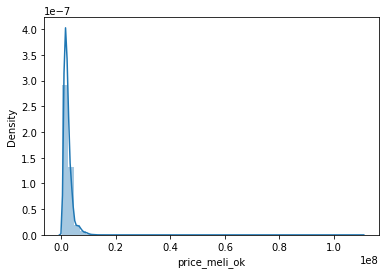

In [81]:
sns.distplot(y_train)

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

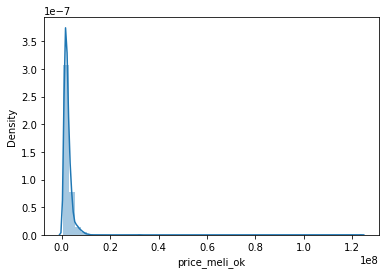

In [82]:
sns.distplot(y_test)

In [83]:
# chequeamos distribuciones de kms en ambos dfs
a = pd.concat([X_train.car_kms.describe(percentiles=[0.005,0.01,0.1,0.25,0.5,0.75,0.9,0.99])
              ,X_test.car_kms.describe(percentiles=[0.005, 0.01,0.1,0.25,0.5,0.75,0.9,0.99])],axis=1)
a.columns = ['kms_train','kms_test']
a

,kms_train,kms_test
count,16509.00,4128.00
mean,105365.74,106764.85
std,78930.72,75461.24
min,103.00,133.00
0.5%,1332.40,2200.00
1%,4008.00,5000.00
10%,31080.00,32000.00
25%,60000.00,62000.00
50%,97000.00,97500.00
75%,139000.00,140000.00


In [84]:
df_train = pd.concat([X_train,y_train],1)
df_test = pd.concat([X_test,y_test],1)

De ahora en más trabajamos solo sobre df_train para evitar data leakage.

In [85]:
del df

### Salvamos los df de train y test

In [86]:
df_train.to_csv('{}df_train_checkpoint_3.pkl'.format(path_save))
df_test.to_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

### *Tratamiento de outliers nº1*

*Vamos a eliminar solamente los outliers más absurdos antes de hacer el split*

In [87]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','match_v1_c', 'Subseg_a', 'Seg_a']
target = ['price_meli_ok']
id_features = ['runtime','car_id']

In [88]:
df_train.price_meli_ok.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count       16509.00
mean      2416787.09
std       2081533.12
min        250000.00
0.5%       639080.00
1%         700000.00
25%       1400000.00
50%       2000000.00
75%       2850000.00
99%       8500000.00
99.5%     9500000.00
99.8%    10996799.02
99.9%    12746000.00
max     110000000.00
Name: price_meli_ok, dtype: float64

In [89]:
# Asi como aca aparece esta Hilux, este tipo de casos los tratamos en el tratamiento de outliers nº2
df_train[df_train.price_meli_ok <= 250000][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
2462,2021.00,960000,FIAT,Cronos,1.3 GSE MT Drive Pack Conectividad (99cv),DRIVE 1.3 MT,Gama Pequenos Sedan,Gama Pequenos


In [90]:
df_train.shape

(16509, 9)

<AxesSubplot:xlabel='price_meli_ok'>

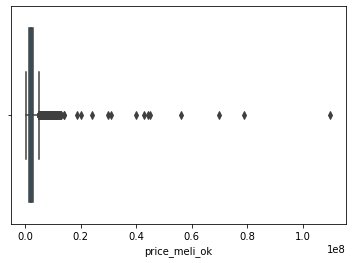

In [91]:
sns.boxplot(df_train.price_meli_ok)

In [92]:
# creamos diccionarios para guardar la info de capeo de outliers
thresh_outliers_1 = {}

In [93]:
# dropmeamos outliers globales de price
p_995 = df_train.price_meli_ok.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['price_p995'] = p_995
mask = df_train.price_meli_ok <= p_995
df_train = df_train[mask]

<AxesSubplot:xlabel='price_meli_ok'>

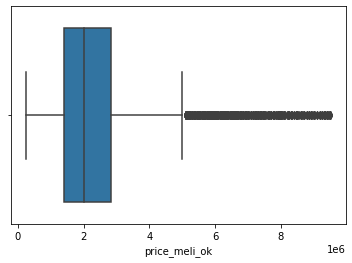

In [94]:
sns.boxplot(df_train.price_meli_ok)

In [95]:
df_train.price_meli_ok.describe(percentiles=[0.001,0.01,0.05,0.1,0.25,0.75,0.99])

count     16431.00
mean    2348751.25
std     1412638.00
min      250000.00
0.1%     500000.00
1%       700000.00
5%       857500.00
10%      980000.00
25%     1400000.00
50%     1999999.00
75%     2850000.00
99%     7700000.00
max     9500000.00
Name: price_meli_ok, dtype: float64

<AxesSubplot:xlabel='price_meli_ok', ylabel='Density'>

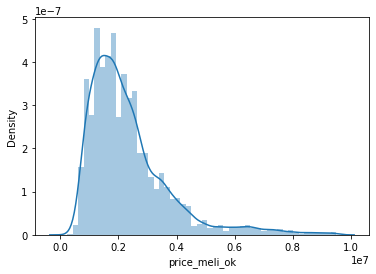

In [96]:
sns.distplot(df_train.price_meli_ok)

In [97]:
# Observamos los casos --> Podemos ver que hay casos como una Kangoo, KA, etc con precios absurdamente altos.
## Casos de este tipo trataremos en el tratamiento de outliers nº2
p_99 = df_train.price_meli_ok.quantile(0.99)
mask = df_train.price_meli_ok >= p_99
df_train[mask][model_features]

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,Subseg_a,Seg_a
2323,2017.00,130000,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),DC V6 EXTREME 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos
5371,2021.00,22000,VOLKSWAGEN,Amarok,2.0 TDI (180cv) 4x4 C/Doble Highline Pack AT,DC 2.0L TDI 180CV HIGHLINE 4X4 AUT EU5,Pickups Medianas-Grandes,Livianos
18157,2021.00,500,TOYOTA,Hilux,4x4 CD SRV 2.8 TDI 6AT Limited (177cv) (L16),4X2 C/D SRV 2.7 VVTI CUERO - B4,Pickups Medianas-Grandes,Livianos
18289,2021.00,32500,TOYOTA,Hilux,4x4 CD SRV 2.8 TDI 6AT Limited (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
20108,2019.00,24000,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
18283,2021.00,4000,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
18306,2021.00,38000,TOYOTA,Hilux,4x4 CD SRV 2.8 TDI 6AT Limited (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
12126,2019.00,65000,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),DC V6 EXTREME 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos
19839,2020.00,25000,TOYOTA,Hilux,4x4 CD SRX 2.8 TDI 6MT (177cv) (L16),4X4,Pickups Medianas-Grandes,Livianos
8836,2018.00,62000,VOLKSWAGEN,Amarok,3.0 TDI V6 (224cv) 4x4 C/Doble Extreme AT (L17),DC V6 EXTREME 3.0L TDI 4X4 A,Pickups Medianas-Grandes,Livianos


In [98]:
df_train.shape

(16431, 9)

*Ahora lo mismo pero para kms**

In [99]:
df_train.car_kms.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.995,0.998,0.999])

count     16431.00
mean     105734.06
std       78883.87
min         103.00
0.5%       1833.00
1%         5000.00
25%       61000.00
50%       97000.00
75%      139997.50
99%      299804.90
99.5%    340000.00
99.8%    407371.48
99.9%    622690.00
max     3500000.00
Name: car_kms, dtype: float64

<AxesSubplot:xlabel='car_kms'>

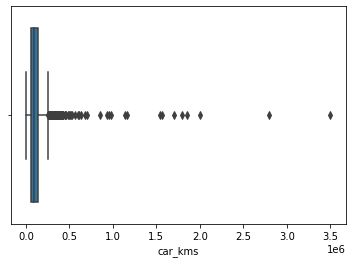

In [100]:
sns.boxplot(df_train.car_kms)

In [101]:
p_995 = df_train.car_kms.quantile(0.995)
# guardamos la info de train para luego aplicarla en test
thresh_outliers_1['kms_p995'] = p_995
mask = df_train.car_kms > p_995
len(df_train[mask])

78

In [102]:
# dropeamos outliers globales de car_kms
df_train = df_train[~mask]

In [103]:
# We are now able to save the dict with the information learned in the train set regarding the thresholds to cap outliers
import json
with open(f'{path_save}thresh_outliers_1.json', 'w') as fp:
    json.dump(thresh_outliers_1, fp)

<AxesSubplot:xlabel='car_kms'>

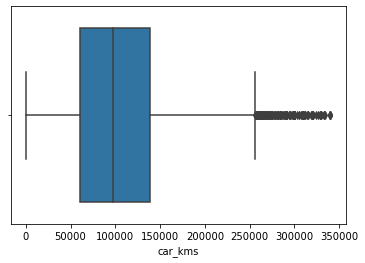

In [104]:
sns.boxplot(df_train.car_kms)

*Revision valores extremos o raros en car_year*

In [105]:
df_train.car_year.describe(percentiles=[0.005, 0.01,0.25,0.75,0.99,0.998,0.999])

count   16353.00
mean     2014.07
std         3.54
min      2006.00
0.5%     2006.00
1%       2006.00
25%      2012.00
50%      2014.00
75%      2017.00
99%      2021.00
99.8%    2021.00
99.9%    2021.00
max      2021.00
Name: car_year, dtype: float64

Vemos que no hay outliers ni casos raros en la variable de año

In [106]:
sorted(df_train.car_year.unique().tolist())

[2006.0,
 2007.0,
 2008.0,
 2009.0,
 2010.0,
 2011.0,
 2012.0,
 2013.0,
 2014.0,
 2015.0,
 2016.0,
 2017.0,
 2018.0,
 2019.0,
 2020.0,
 2021.0]

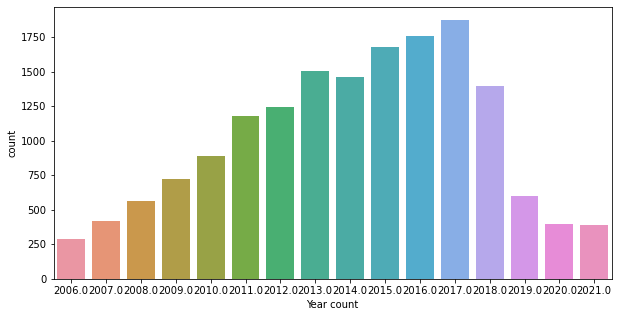

In [107]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
sns.countplot(df_train.car_year)
plt.xlabel("Year count")
plt.show()

In [108]:
df_train['car_year'] = df_train['car_year'].astype('int')

***Fin del tratamiento de outliers nº1***

# Univariado + Bivariado + Cleaning

* Luego volver a correr este bivariado pero sumandole el nivel año a la agregación, luego y hacer una funcion que capee los valores que traspasen los whiskers en cada agrupacion (ej: toyota - hilux - 2020) tanto para km como para precios.
* Usar la version acara en lugarde la de camval
* Mirar los errores en la perfo del modelo, no solo el R2 (la func evaluate que use para airtm)

In [109]:
df_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'match_v1_c', 'Subseg_a', 'Seg_a', 'price_meli_ok'],
      dtype='object')

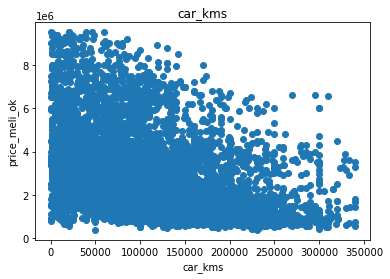

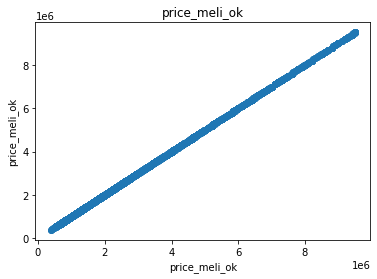

In [110]:
for feature in ['car_kms','price_meli_ok']:
    plt.scatter(df_train[feature],df_train['price_meli_ok'])
    plt.xlabel(feature)
    plt.ylabel('price_meli_ok')
    plt.title(feature)
    plt.show()

In [111]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Corolla', 'Hilux', 'Etios'], dtype=object)

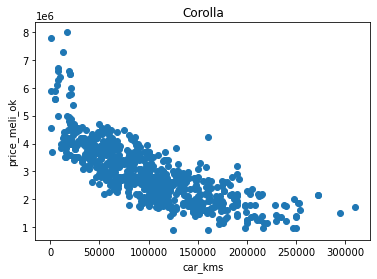

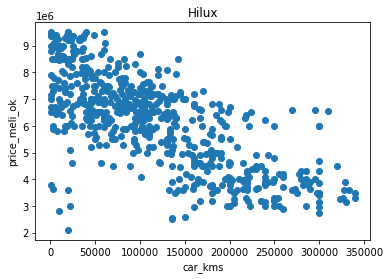

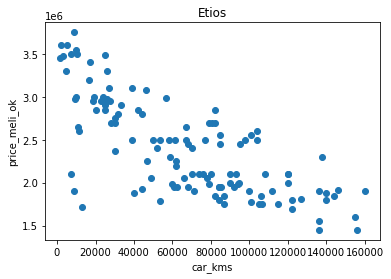

In [112]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.scatter(data[sub_mask]['car_kms'],data[sub_mask]['price_meli_ok'])
    plt.xlabel('car_kms')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

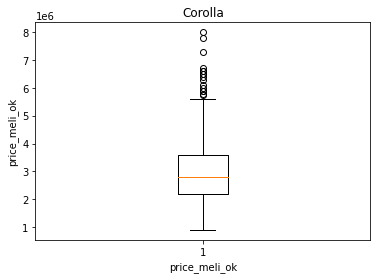

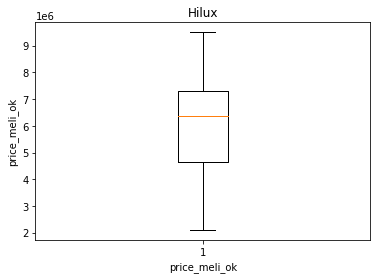

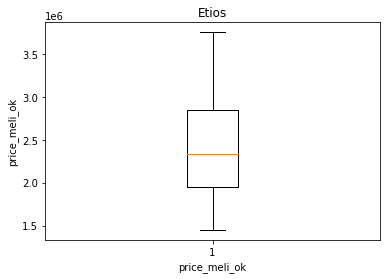

In [113]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['price_meli_ok'])
    plt.xlabel('price_meli_ok')
    plt.ylabel('price_meli_ok')
    plt.title(i)
    plt.show()

Vamos a chequear si los detectamos con la formula q3+1.5*IQR

In [114]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

4201125.0
0


In [115]:
mask = df_train.match_modelo_a == 'Hilux'
data = df_train[mask].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>=outl_thresh_superior]))

11275000.0
0


Perfect

*Lo mismo para kms*

In [116]:
mask = df_train.match_marca_a == 'TOYOTA'
data = df_train[mask]
modelos = data.match_modelo_a.unique()
modelos

array(['Corolla', 'Hilux', 'Etios'], dtype=object)

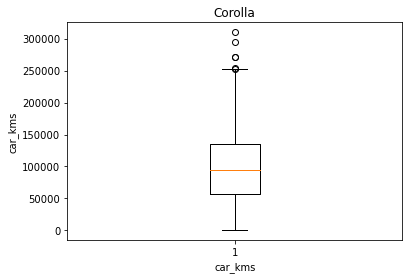

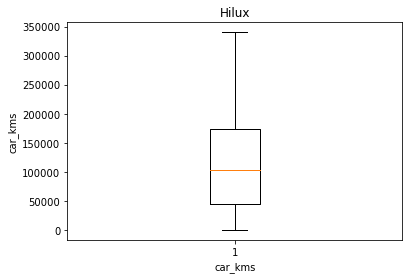

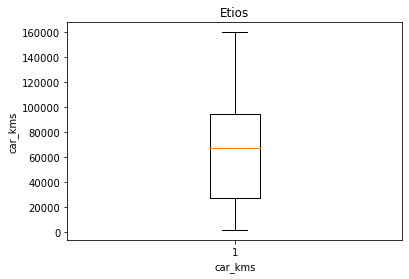

In [117]:
for i in modelos:
    sub_mask = data.match_modelo_a == i
    plt.boxplot(data[sub_mask]['car_kms'])
    plt.xlabel('car_kms')
    plt.ylabel('car_kms')
    plt.title(i)
    plt.show()

In [118]:
mask = df_train.match_modelo_a == 'Etios'
data = df_train[mask].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

194500.0
0


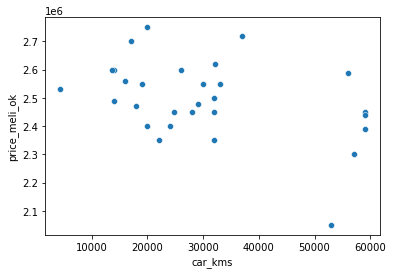

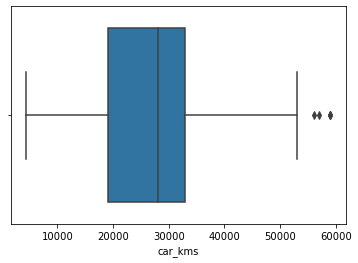

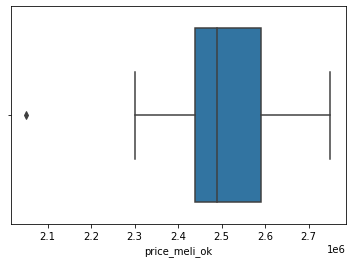

In [119]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

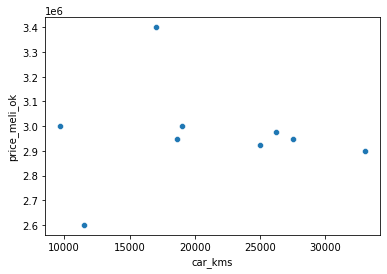

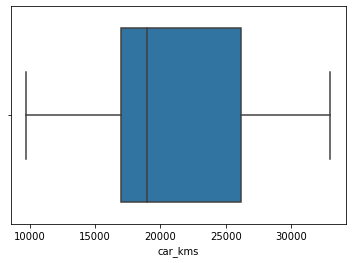

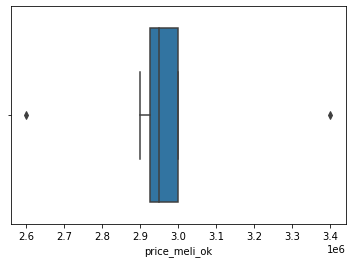

In [120]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()
#df_train[mask1 & mask2 & mask3].groupby('car_year')['price_meli_ok'].mean().plot.bar()
#plt.show()

In [121]:
mask1 = df_train.match_modelo_a == 'Etios'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.car_kms.quantile(0.25)
q3 = data.car_kms.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.car_kms>=outl_thresh_superior]))

40000.0
0


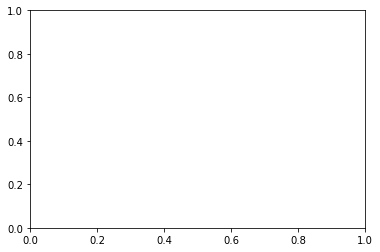

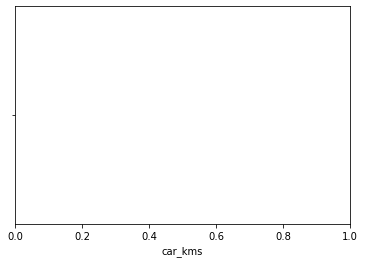

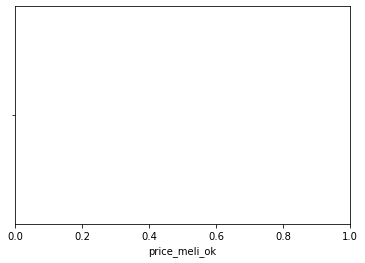

In [122]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'T-Cross'
#mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2]['car_kms'],df_train[mask1 & mask2]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2]['price_meli_ok'],)
plt.show()

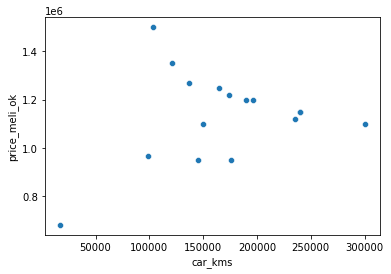

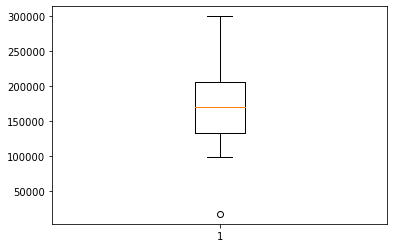

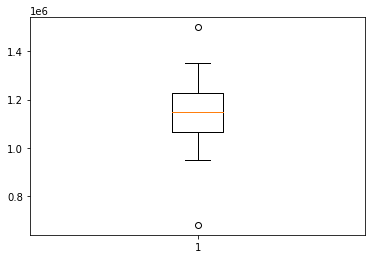

In [123]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

Aca podemos chequear el valor extremo de la Kangoo que hace que haya aparecido cuando nos fijamos los registros que quedaban por encima del p99 luego de haber hecho el tratamiento de outliers nº1.

También es interesante observar en el boxplot de kms como sale un outlier inferior: es imposible (o demasiado raro) que una kangoo del 2009 tenga menos de 10.000 kms. Todos estos casos ilogicos los vamos a estar eliminando en esta seccion "Tratamiento de outliers nº2"

In [124]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

1469375.0
1


In [125]:
mask1 = df_train.match_modelo_a == 'Kangoo'
mask2 = df_train.car_year == 2009
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_inferior = q1-1.5*IQR
print(outl_thresh_inferior)
print(len(data[data.price_meli_ok<outl_thresh_inferior]))

824375.0
1


---

### *Tratamiento de outliers nº2*
* Es un tratamiento profundo donde buscamos **outliers por contexto** (outliers a nivel de agg marca-modelo-año)
* Notar que se hace despues del Split sobre el train, para evitar data leakage! Es decir: fit_transform sobre train y transform sobre test
* Luego lo aplicaremos sobre test pero con los thresholds de outliers aprendidos en train.

In [126]:
df_train['car_year'].dtype

dtype('int64')

In [127]:
# Dropeamos todos los outliers por contexo: "Tratamiento de outliers nº2"

modelos = sorted(list(df_train.match_modelo_a.unique()))
años = sorted(list(df_train.car_year.unique()))
kms_thresh_outliers = {}
price_thresh_outliers = {}
old_shape = df_train.shape[0]
for m in modelos:
    for a in años:
        # print(f'{m} of {a}') --> solo para chequear que el loop este iterando correctamente (esta OK :)
        
        modelo_año = m + '_' + str(a)
        
        
        # kms
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.car_kms.quantile(0.25)
        q3 = data.car_kms.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        kms_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.car_kms>kms_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.car_kms<kms_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)
        
        # price
        mask1 = df_train.match_modelo_a == m
        mask2 = df_train.car_year == a
        data = df_train[mask1 & mask2].copy()
        
        q1 = data.price_meli_ok.quantile(0.25)
        q3 = data.price_meli_ok.quantile(0.75)
        IQR = q3 - q1
        outl_thresh_superior = q3+3*IQR
        outl_thresh_inferior = q1-3*IQR
        price_thresh_outliers[modelo_año] = (outl_thresh_inferior,outl_thresh_superior)
        filt_mask_sup = data.price_meli_ok>price_thresh_outliers[modelo_año][1]
        filt_mask_inf = data.price_meli_ok<price_thresh_outliers[modelo_año][0]
        data = data[~(filt_mask_sup | filt_mask_inf)]
        df_train = df_train.loc[~(mask1 & mask2),:]
        df_train = pd.concat([df_train,data],0)

print(f'Hey! {old_shape - df_train.shape[0]} were removed from df_train due to outliers under context')        

Hey! 166 were removed from df_train due to outliers under context


In [128]:
kms_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (-36000.0, 167000.0),
 '2008_2017': (-57600.0, 181800.0),
 '2008_2018': (-56875.0, 150500.0),
 '2008_2019': (-1250.0, 54750.0),
 '2008_2020': (-35396.0, 68984.5),
 '2008_2021': (-15250.0, 33750.0),
 '206_2006': (103000.0, 208000.0),
 '206_2007': (-46000.0, 332000.0),
 '206_2008': (37000.0, 269750.0),
 '206_2009': (-94250.0, 394000.0),
 '206_2010': (10000.0, 283000.0),
 '206_2011': (-35000.0, 315000.0),
 '206_2012': (39500.0, 141000.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_2007': (nan, nan),
 '207_2008'

**Chequeos**

In [129]:
df_train.shape

(16187, 9)

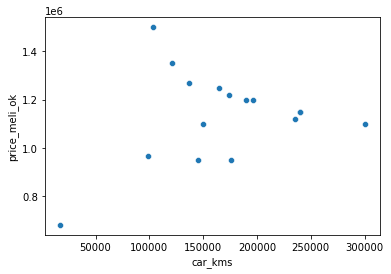

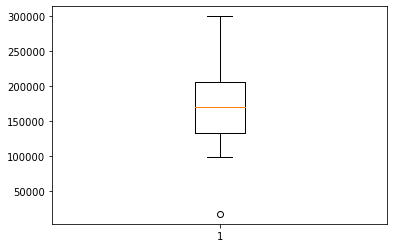

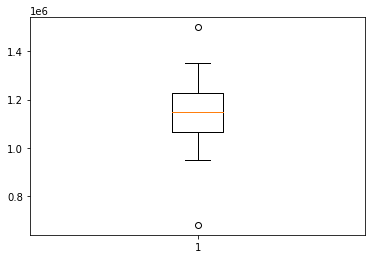

In [130]:
mask1 =df_train.match_marca_a == 'RENAULT'
mask2 =df_train.match_modelo_a == 'Kangoo'
mask3 =df_train.car_year == 2009

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
plt.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

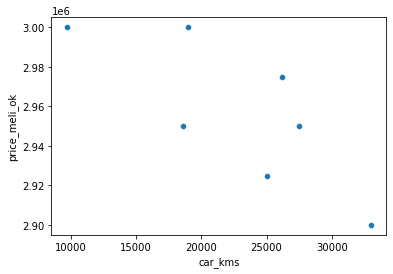

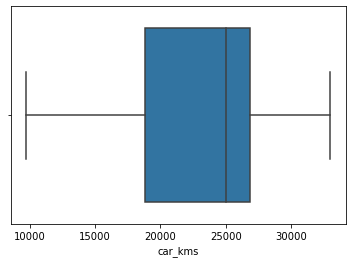

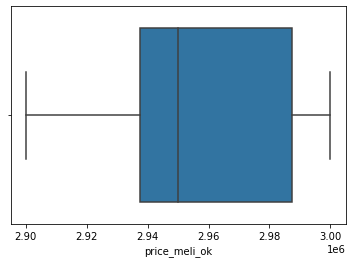

In [131]:
mask1 =df_train.match_marca_a == 'TOYOTA'
mask2 =df_train.match_modelo_a == 'Etios'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

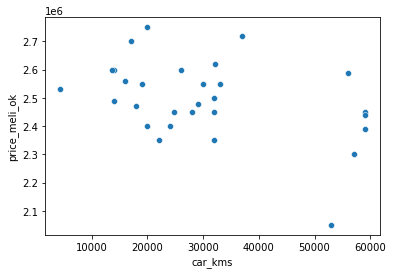

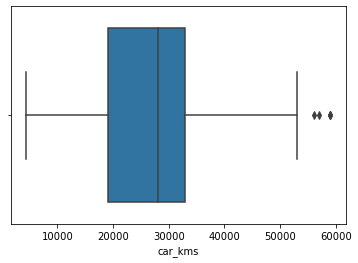

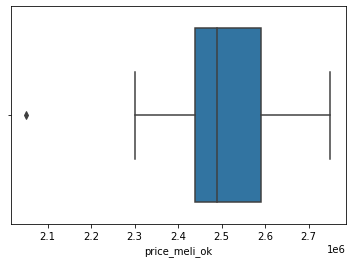

In [132]:
mask1 =df_train.match_marca_a == 'VOLKSWAGEN'
mask2 =df_train.match_modelo_a == 'Gol Trend'
mask3 =df_train.car_year == 2019
#mask3 =df_train.match_v1_a == '1.6 3Ptas. Trendline / Pack I (101cv) '

sns.scatterplot(df_train[mask1 & mask2 & mask3]['car_kms'],df_train[mask1 & mask2 & mask3]['price_meli_ok']);
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['car_kms'])
plt.show()
sns.boxplot(df_train[mask1 & mask2 & mask3]['price_meli_ok'],)
plt.show()

In [133]:
mask1 = df_train.match_modelo_a == 'Gol Trend'
mask2 = df_train.car_year == 2019
data = df_train[mask1 & mask2].copy()
q1 = data.price_meli_ok.quantile(0.25)
q3 = data.price_meli_ok.quantile(0.75)
IQR = q3 - q1
outl_thresh_superior = q3+1.5*IQR
print(outl_thresh_superior)
print(len(data[data.price_meli_ok>outl_thresh_superior]))

2815000.0
0


Si bien es cierto que siguen apareciendo outliers, esto es normal debido a que con el tratamiento que hicimos la distribucion cambia y es logico que ahora un valor que antes no se consideraba outliers si se considere. Lo bueno es que ahora estos outliers ya no son tan extremos e irriorios.

In [134]:
price_thresh_outliers

{'2008_2006': (nan, nan),
 '2008_2007': (nan, nan),
 '2008_2008': (nan, nan),
 '2008_2009': (nan, nan),
 '2008_2010': (nan, nan),
 '2008_2011': (nan, nan),
 '2008_2012': (nan, nan),
 '2008_2013': (nan, nan),
 '2008_2014': (nan, nan),
 '2008_2015': (nan, nan),
 '2008_2016': (1650000.0, 3750000.0),
 '2008_2017': (1520000.0, 4372500.0),
 '2008_2018': (1295000.0, 5040000.0),
 '2008_2019': (1912502.25, 5499997.0),
 '2008_2020': (1550000.0, 6187500.0),
 '2008_2021': (1572500.0, 6892500.0),
 '206_2006': (150000.0, 1550000.0),
 '206_2007': (575000.0, 1205000.0),
 '206_2008': (330000.0, 1485000.0),
 '206_2009': (533750.0, 1172500.0),
 '206_2010': (130000.0, 1810000.0),
 '206_2011': (380000.0, 1640000.0),
 '206_2012': (670000.0, 1510000.0),
 '206_2013': (nan, nan),
 '206_2014': (nan, nan),
 '206_2015': (nan, nan),
 '206_2016': (nan, nan),
 '206_2017': (nan, nan),
 '206_2018': (nan, nan),
 '206_2019': (nan, nan),
 '206_2020': (nan, nan),
 '206_2021': (nan, nan),
 '207_2006': (nan, nan),
 '207_200

In [135]:
# Guardamos los diccionarios con la info de outiers thresholds en formato json
with open('{}kms_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(kms_thresh_outliers, outfile)

with open('{}price_thresh_outliers.json'.format(path_save), 'w') as outfile:
    json.dump(price_thresh_outliers, outfile)

Notesé que en muchos casos nos quedan "nan", eso es porque aveces no tenemos ningun registro de un marca-modelo para un cierto año en particular (ej: talvez no se fabrico ese modelo durante ese año o cosas así). Por lo único que tendremos que tener cuidado es cuando apliquemos este cleaning sobre test, vamos a tener que poner un "if" que haga un "pass" en caso de que los thresh seas "nan"

In [136]:
df_train.to_csv('{}df_train_checkpoint_4.pkl'.format(path_save)) # este es el df_train final!
# el test sigue igual

# Applying data cleaning in the test set

In [137]:
df_train_ok = pd.read_csv('{}df_train_checkpoint_4.pkl'.format(path_save))

In [138]:
df_test = pd.read_csv('{}df_test_checkpoint_3.pkl'.format(path_save))

In [139]:
print(df_train_ok.shape)
print(df_test.shape)

(16187, 10)
(4128, 10)


In [140]:
# Aplicamos el data cleaning aprendido en train sobre el set de test para usarlo en la evaluacion
df_test_ok = data_processing_1(df_test,path_save)

Hey! 41 were removed due to outliers globales
Hey! 111 were removed from df due to outliers under context


In [141]:
df_test_ok.shape

(3976, 10)

In [142]:
df_test_ok.to_csv('{}df_test_checkpoint_4.pkl'.format(path_save)) # este es el df_test final!

In [143]:
df_test_ok = pd.read_csv('{}df_test_checkpoint_4.pkl'.format(path_save))
df_test_ok.shape

(3976, 11)

# Modelling

In [144]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [145]:
# Volvemos a separar en X e y
X_train = df_train_ok[model_features]
y_train = df_train_ok.price_meli_ok

X_test = df_test_ok[model_features]
y_test = df_test_ok.price_meli_ok

## Modelo Baseline

In [146]:
X_train.columns

Index(['car_year', 'car_kms', 'match_marca_a', 'match_modelo_a', 'match_v1_a',
       'Subseg_a', 'Seg_a'],
      dtype='object')

In [147]:
# Recordar agregar esto en la funcion de procesamiento para la simulacion

# Cuando hice el tratamiento de 1111 y 99999 había pasado la feature de kms a int. Volvemos a pasar a float por el catboost
X_train['car_kms'] = X_train['car_kms'].astype('float')
X_test['car_kms'] = X_test['car_kms'].astype('float')

# probamos tanto usando year como int y como float y la perfo del modelo dio apenas mejor con year en float
X_train['car_year'] = X_train['car_year'].astype('float')
X_test['car_year'] = X_test['car_year'].astype('float')

In [148]:
X_train.dtypes

car_year          float64
car_kms           float64
match_marca_a      object
match_modelo_a     object
match_v1_a         object
Subseg_a           object
Seg_a              object
dtype: object

In [149]:
np.where(X_train[model_features].dtypes != np.float)[0]

array([2, 3, 4, 5, 6])

In [150]:
# model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
# categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
# model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

# train_pred = model.predict(X_train)
# test_pred = model.predict(X_test)

# print('Train set evaluation:\n_____________________________________')
# print_evaluate(y_train, train_pred)
# print('Test set evaluation:\n_____________________________________')
# print_evaluate(y_test, test_pred)

In [151]:
# model.get_feature_importance(prettified=True)

In [152]:
model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)

Train set evaluation:
_____________________________________
MAE: 156260.37711180924
MAPE: 7.540439733288808
MEDAPE: 5.668188746777865
MSE: 48633979783.34975
RMSE: 220531.13109796937
R2 Square 0.9756278578362962
__________________________________
Test set evaluation:
_____________________________________
MAE: 169318.20263838608
MAPE: 7.872342257876499
MEDAPE: 5.887292768931799
MSE: 61553841762.41414
RMSE: 248100.46707415555
R2 Square 0.9700990562951365
__________________________________


In [153]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Subseg_a,31.79
1,car_year,29.46
2,match_marca_a,13.91
3,match_modelo_a,9.91
4,match_v1_a,5.56
5,Seg_a,5.15
6,car_kms,4.22


In [154]:
# Save del modelo fiteado

path_model_save = '../model/'

import pickle
with open('{}model_catboost_v4.pickle'.format(path_model_save), 'wb') as f:
    pickle.dump(model, f)

---

### Model assesment (on test set)

In [155]:
test_pred = pd.Series(test_pred,name='test_pred')
d = pd.concat([X_test, y_test, test_pred],1)

In [156]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,test_pred
0,2013.00,136000.00,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1248739.17
1,2006.00,185721.00,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1200000,960675.00
2,2019.00,60000.00,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73
3,2016.00,58000.00,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,2550000,2805047.77
4,2016.00,75000.00,PEUGEOT,2008,1.6 16v. Allure MT (115cv),Suv Compactas 4x2,SUV,3100000,2408369.01


In [157]:
y_test = d['price_meli_ok']
deciles_y_true = y_test.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [ ]:
dic

{'d1': 990000.0,
 'd2': 1293000.0,
 'd3': 1500000.0,
 'd4': 1750000.0,
 'd5': 1950000.0,
 'd6': 2257999.999999997,
 'd7': 2600000.0,
 'd8': 3150000.0,
 'd9': 3990000.0,
 'd10': 9400000.0}

In [158]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_test <= dic['d1'], 'd01',
                       np.where((y_test > dic['d1']) & (y_test <= dic['d2']), 'd02',
                               np.where((y_test > dic['d2']) & (y_test <= dic['d3']), 'd03',
                                       np.where((y_test > dic['d3']) & (y_test <= dic['d4']), 'd04',
                                               np.where((y_test > dic['d4']) & (y_test <= dic['d5']), 'd05',
                                                       np.where((y_test > dic['d5']) & (y_test <= dic['d6']), 'd06',
                                                               np.where((y_test > dic['d6']) & (y_test <= dic['d7']), 'd07',
                                                                       np.where((y_test > dic['d7']) & (y_test <= dic['d8']), 'd08',
                                                                               np.where((y_test > dic['d8']) & (y_test <= dic['d9']), 'd09',
                                                                                       np.where((y_test > dic['d9']) & (y_test <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [159]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,test_pred,y_true_disc
0,2013.00,136000.00,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1248739.17,d03
1,2006.00,185721.00,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1200000,960675.00,d02
2,2019.00,60000.00,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73,d03
3,2016.00,58000.00,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,2550000,2805047.77,d07
4,2016.00,75000.00,PEUGEOT,2008,1.6 16v. Allure MT (115cv),Suv Compactas 4x2,SUV,3100000,2408369.01,d08
5,2016.00,103000.00,PEUGEOT,2008,1.6 THP Sport Tiptronic (165cv) (L20),Suv Compactas 4x2,SUV,2850000,2607631.57,d08
6,2016.00,100000.00,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,3500000,2616829.07,d09
7,2016.00,72000.00,PEUGEOT,2008,1.6 16v. Allure MT (115cv),Suv Compactas 4x2,SUV,2500000,2409202.11,d07
8,2016.00,59000.00,PEUGEOT,2008,1.6 16v. Allure MT (115cv),Suv Compactas 4x2,SUV,2700000,2492944.86,d08
9,2016.00,43000.00,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,2700000,2922943.56,d08


In [160]:
# Accuracy
d['menos20perc'] = d.test_pred * 0.90
d['mas20perc'] = d.test_pred * 1.10
d['menos20perc'] = d['menos20perc'].astype('int')
d['mas20perc'] = d['mas20perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos20perc']) & (d['price_meli_ok']<=d['mas20perc']),1,0)

In [161]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,test_pred,y_true_disc,menos20perc,mas20perc,falls_in_range
0,2013.00,136000.00,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1248739.17,d03,1123865,1373613,0
1,2006.00,185721.00,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1200000,960675.00,d02,864607,1056742,0
2,2019.00,60000.00,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73,d03,2035754,2488144,0
3,2016.00,58000.00,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,2550000,2805047.77,d07,2524542,3085552,1
4,2016.00,75000.00,PEUGEOT,2008,1.6 16v. Allure MT (115cv),Suv Compactas 4x2,SUV,3100000,2408369.01,d08,2167532,2649205,0


In [162]:
# Overall Accuracy
d.falls_in_range.mean()

0.7245975855130785

In [163]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.52
1,d02,0.68
2,d03,0.75
3,d04,0.68
4,d05,0.76
5,d06,0.79
6,d07,0.75
7,d08,0.80
8,d09,0.77
9,d10,0.76


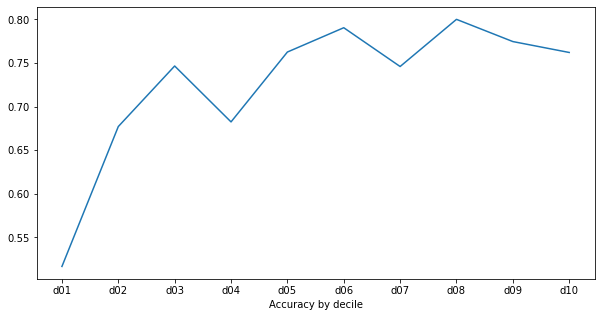

In [164]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("Accuracy by decile")
plt.show()

* Luego lo que podemos hacer es hacer aca mismo la validacion out of time arrancando de cero, sin mirar la nb de simulacion porque tal vez el error esta en ese codigo del output final

## Validacion OOT
fecha: 20 de abril

In [165]:
# checkpoint upload
df_scoreo_oot = pd.read_csv('{}df_score_oot_checkpoint.csv'.format(path_save))

In [166]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

105549
2022-04-20 2022-04-20


In [167]:
# Creamos la feature marca_modelo_version ya que necesitamos tenerla en el df para las funciones de limpieza
df_scoreo_oot['marca_modelo_version'] = df_scoreo_oot['match_marca_a'] + str(' - ') +df_scoreo_oot['match_modelo_a'] + str(' - ') + df_scoreo_oot['match_v1_a']

In [168]:
# aplicamos la limpieza pre split
df_scoreo_oot = data_cleaning_valset(df_scoreo_oot)

Hey! 0 were removed due to null values
Hey! 7393 were removed due to duplicate values
Hey! 745 were removed due those 11111 or 9999 strange values
Hey! 10611 were removed due prices in dollars
Hey! 50833 were removed due to 0km or concesioarias
Hey! 7152 were removed due to match scores under 80%
Hey! 0 were removed due to last 15d filter
Hey! 13083 were removed due to categories in which we are not interested in score


In [169]:
# aplicamos la limpieza post split
df_scoreo_oot = data_processing_1(df_scoreo_oot,path_save)

Hey! 168 were removed due to outliers globales
Hey! 217 were removed from df due to outliers under context


In [171]:
df_scoreo_oot.shape

(15347, 13)

In [170]:
X_oot = df_scoreo_oot[model_features].copy()
y_oot = df_scoreo_oot.price_meli_ok.copy()

In [172]:
# Assesment
oot_pred = model.predict(X_oot)

print('OOT set evaluation:\n_____________________________________')
print_evaluate(y_oot, oot_pred)

OOT set evaluation:
_____________________________________
MAE: 160322.0099426835
MAPE: 7.401710764945426
MEDAPE: 5.661114243686885
MSE: 51931031355.83297
RMSE: 227883.81108765266
R2 Square 0.974002267185014
__________________________________


### Model assesment (on validation/oot set)

In [203]:
oot_pred = pd.Series(oot_pred,name='oot_pred')
d = pd.concat([X_oot.reset_index(drop=True), y_oot.reset_index(drop=True), oot_pred],1)

In [204]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32
1,2006.00,185721,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1200000,960675.00
2,2013.00,136000,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1248739.17
3,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73
4,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74


In [205]:
y_val = d['price_meli_ok']
deciles_y_true = y_val.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [206]:
dic

{'d1': 1000000.0,
 'd2': 1300000.0,
 'd3': 1550000.0,
 'd4': 1800000.0,
 'd5': 2070000.0,
 'd6': 2350000.0,
 'd7': 2650000.0,
 'd8': 3200000.0,
 'd9': 4100000.0,
 'd10': 9500000.0}

In [207]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_val <= dic['d1'], 'd01',
                       np.where((y_val > dic['d1']) & (y_val <= dic['d2']), 'd02',
                               np.where((y_val > dic['d2']) & (y_val <= dic['d3']), 'd03',
                                       np.where((y_val > dic['d3']) & (y_val <= dic['d4']), 'd04',
                                               np.where((y_val > dic['d4']) & (y_val <= dic['d5']), 'd05',
                                                       np.where((y_val > dic['d5']) & (y_val <= dic['d6']), 'd06',
                                                               np.where((y_val > dic['d6']) & (y_val <= dic['d7']), 'd07',
                                                                       np.where((y_val > dic['d7']) & (y_val <= dic['d8']), 'd08',
                                                                               np.where((y_val > dic['d8']) & (y_val <= dic['d9']), 'd09',
                                                                                       np.where((y_val > dic['d9']) & (y_val <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [208]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32,d09
1,2006.00,185721,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1200000,960675.00,d02
2,2013.00,136000,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1248739.17,d03
3,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73,d02
4,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74,d09
5,2016.00,77000,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,2750000,2707421.62,d08
6,2016.00,91000,PEUGEOT,2008,1.6 THP Sport Tiptronic (165cv) (L20),Suv Compactas 4x2,SUV,2850000,2657226.23,d08
7,2016.00,103000,PEUGEOT,2008,1.6 THP Sport Tiptronic (165cv) (L20),Suv Compactas 4x2,SUV,2850000,2607631.57,d08
8,2016.00,97000,PEUGEOT,2008,1.6 16v. Allure MT (115cv),Suv Compactas 4x2,SUV,2500000,2363771.30,d07
9,2016.00,50000,PEUGEOT,2008,1.6 THP Sport Tiptronic (165cv) (L20),Suv Compactas 4x2,SUV,2860000,2867455.71,d08


In [210]:
# Accuracy
d['menos10perc'] = d.oot_pred * 0.90
d['mas10perc'] = d.oot_pred * 1.10
d['menos10perc'] = d['menos10perc'].astype('int')
d['mas10perc'] = d['mas10perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos10perc']) & (d['price_meli_ok']<=d['mas10perc']),1,0)

In [211]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc,menos10perc,mas10perc,falls_in_range
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32,d09,2868656,3506135,0
1,2006.00,185721,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1200000,960675.00,d02,864607,1056742,0
2,2013.00,136000,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1248739.17,d03,1123865,1373613,0
3,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73,d02,2035754,2488144,0
4,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74,d09,3568600,4361622,1


In [212]:
# Overall Accuracy
d.falls_in_range.mean()

0.744184531178732

In [213]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.54
1,d02,0.70
2,d03,0.69
3,d04,0.72
4,d05,0.79
5,d06,0.80
6,d07,0.77
7,d08,0.80
8,d09,0.83
9,d10,0.81


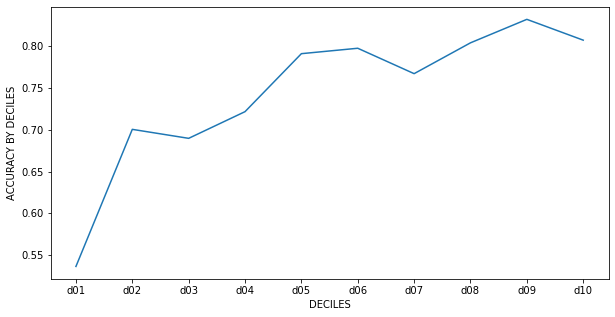

In [216]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("DECILES")
plt.ylabel("ACCURACY BY DECILES")
plt.show()

### Final Output

In [195]:
extra_features = ['car_id','match_v1_c','car_location_1']
data_output = pd.concat([df_scoreo_oot[extra_features].reset_index(drop=True)
                         ,X_oot.reset_index(drop=True)
                         ,pd.Series(y_oot,name='y_oot').reset_index(drop=True)
                         ,pd.Series(oot_pred,name='oot_pred')],1)
data_output

# faltaría sumarle una que indique el grupo de presencialidad (previo a eso re-entrenar sumando grupo 2 y 3 y ver como impacta en la perfo)

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred
0,1132553124,RS,Bs.As. G.B.A. Oeste,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32
1,1130837085,CONFORT 1.4,Capital Federal,2006.00,185721,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1200000,960675.00
2,1128395312,LT 1.6,Bs.As. G.B.A. Sur,2013.00,136000,CHEVROLET,Aveo,LT 1.6 AT 4Ptas. (103cv),Gama Pequenos Sedan,Gama Pequenos,1400000,1248739.17
3,1125369119,WAY 1.3 MPI 8V,Bs.As. G.B.A. Norte,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73
4,1133063732,1.6,Capital Federal,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74
...,...,...,...,...,...,...,...,...,...,...,...,...
15342,1125175711,1.6,Bs.As. G.B.A. Sur,2014.00,92000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1540000,1532898.00
15343,1130493870,1.6,Bs.As. G.B.A. Sur,2014.00,220000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1150000,1291173.97
15344,1128137098,1.6,Bs.As. G.B.A. Sur,2014.00,290000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1300000,1235858.87
15345,1131292866,1.6,Capital Federal,2014.00,175000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1300000,1352074.75


In [197]:
# chequeo (tiene que mantenerse igual que el anterior) -- OK
print('OOT set evaluation:\n_____________________________________')
print_evaluate(data_output.y_oot, data_output.oot_pred)

OOT set evaluation:
_____________________________________
MAE: 160322.0099426835
MAPE: 7.401710764945426
MEDAPE: 5.661114243686885
MSE: 51931031355.83297
RMSE: 227883.81108765266
R2 Square 0.974002267185014
__________________________________


---

In [217]:
# AGREGAR AL MODEL ASSESMENT UNA TABLA QUE QUEDE IDENTICA A LA QUE ME PASO DANI DEL EXAMEN DE LA CHICA PARA RAPPI (drive Kardur)

## Validacion OOT
fecha: 27 de abril

In [5]:
# Importar tabla de Big Query
query = '''SELECT *
           FROM `data-team-k.pricing_data.match_meli_ok`
           WHERE date > "2022-04-21" 
            '''
df_scoreo_oot = gbq.read_gbq(query, project_id="data-team-k")

In [6]:
df_scoreo_oot.shape

(557511, 42)

In [7]:
# checkpoint upload
df_scoreo_oot.to_csv('{}df_score_oot_mayor_2204.csv'.format(path_save))

In [8]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

557511
2022-04-22 00:00:00 2022-04-26 00:00:00


In [9]:
# Creamos la feature marca_modelo_version ya que necesitamos tenerla en el df para las funciones de limpieza
df_scoreo_oot['marca_modelo_version'] = df_scoreo_oot['match_marca_a'] + str(' - ') +df_scoreo_oot['match_modelo_a'] + str(' - ') + df_scoreo_oot['match_v1_a']

In [10]:
# aplicamos la limpieza pre split
df_scoreo_oot = cleaning_before_split(df_scoreo_oot)

Hey! 242 were removed due to null values
Hey! 443424 were removed due to duplicate values
Hey! 863 were removed due those 11111 or 9999 strange values
Hey! 12545 were removed due prices in dollars
Hey! 57663 were removed due to 0km or concesioarias
Hey! 8386 were removed due to match scores under 80%
Hey! 0 were removed due to last 15d filter
Hey! 15689 were removed due to categories in which we are not interested in score


In [11]:
df_scoreo_oot.shape

(18699, 13)

In [12]:
# aplicamos la limpieza post split
df_scoreo_oot = cleaning_after_split(df_scoreo_oot,path_save)

Hey! 180 were removed due to outliers globales
Hey! 308 were removed from df due to outliers under context


In [13]:
df_scoreo_oot.shape

(18211, 13)

In [14]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [18]:
import pickle
path_model = '../model/'
with open('{}model_catboost_v4.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [19]:
X_oot = df_scoreo_oot[model_features].copy()
y_oot = df_scoreo_oot.price_meli_ok.copy()

In [20]:
# Assesment
oot_pred = model.predict(X_oot)

print('OOT set evaluation:\n_____________________________________')
print_evaluate(y_oot, oot_pred)

OOT set evaluation:
_____________________________________
MAE: 162295.93690921937
MAPE: 7.426014964084057
MEDAPE: 5.698286291538135
MSE: 54043028826.101875
RMSE: 232471.56562922243
R2 Square 0.9733593177403232
__________________________________


### Model assesment (on validation/oot set)

In [21]:
oot_pred = pd.Series(oot_pred,name='oot_pred')
d = pd.concat([X_oot.reset_index(drop=True), y_oot.reset_index(drop=True), oot_pred],1)

In [22]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32
1,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74
2,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2616370.00
3,2013.00,130000,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,1300000,2100820.25
4,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1184659.46


In [23]:
y_val = d['price_meli_ok']
deciles_y_true = y_val.quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])

dic = {}
for i in range(1,10+1):
    dic['d{}'.format(i)] = deciles_y_true.values[i-1]

In [24]:
dic

{'d1': 1050000.0,
 'd2': 1300000.0,
 'd3': 1550000.0,
 'd4': 1800000.0,
 'd5': 2050000.0,
 'd6': 2350000.0,
 'd7': 2650000.0,
 'd8': 3250000.0,
 'd9': 4150000.0,
 'd10': 9500000.0}

In [25]:
# We discretize the vector of true labels to see it in deciles
d['y_true_disc'] = np.where(y_val <= dic['d1'], 'd01',
                       np.where((y_val > dic['d1']) & (y_val <= dic['d2']), 'd02',
                               np.where((y_val > dic['d2']) & (y_val <= dic['d3']), 'd03',
                                       np.where((y_val > dic['d3']) & (y_val <= dic['d4']), 'd04',
                                               np.where((y_val > dic['d4']) & (y_val <= dic['d5']), 'd05',
                                                       np.where((y_val > dic['d5']) & (y_val <= dic['d6']), 'd06',
                                                               np.where((y_val > dic['d6']) & (y_val <= dic['d7']), 'd07',
                                                                       np.where((y_val > dic['d7']) & (y_val <= dic['d8']), 'd08',
                                                                               np.where((y_val > dic['d8']) & (y_val <= dic['d9']), 'd09',
                                                                                       np.where((y_val > dic['d9']) & (y_val <= dic['d10']), 'd10','out_of_bounds'))))))))))

In [26]:
d.head(10)

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32,d09
1,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74,d09
2,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2616370.00,d02
3,2013.00,130000,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,1300000,2100820.25,d02
4,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1184659.46,d02
5,2015.00,50000,VOLKSWAGEN,Bora,2.0 Trendline MT,Gama Medianos Sedan,Gama Medianos,2000000,2273846.62,d05
6,2019.00,60000,FIAT,Uno,Fire 1.3 Pack C / Way (68cv) 5Ptas.,Gama Pequenos Hatchback,Gama Pequenos,1300000,2261949.73,d02
7,2006.00,185721,PEUGEOT,Partner,Furgón 1.4 Confort AA PLC,Baja PU - Furgones,Livianos,1000000,960675.00,d01
8,2019.00,60000,PEUGEOT,Partner,Furgón 1.6 Hdi Confort ABG (90cv) (L10),Baja PU - Furgones,Livianos,2930000,2855003.41,d08
9,2019.00,65000,PEUGEOT,Partner,Furgón 1.6 Hdi Confort ABG (90cv) (L10),Baja PU - Furgones,Livianos,2650000,2841764.85,d07


In [45]:
# Accuracy
d['menos10perc'] = d.oot_pred * 0.93
d['mas10perc'] = d.oot_pred * 1.07
d['menos10perc'] = d['menos10perc'].astype('int')
d['mas10perc'] = d['mas10perc'].astype('int')
d['falls_in_range'] = np.where(
    (d['price_meli_ok']>=d['menos10perc']) & (d['price_meli_ok']<=d['mas10perc']),1,0)

In [46]:
d.head()

,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,oot_pred,y_true_disc,menos10perc,mas10perc,falls_in_range
0,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32,d09,2964278,3410514,0
1,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74,d09,3687553,4242669,0
2,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2616370.00,d02,2433224,2799515,0
3,2013.00,130000,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,1300000,2100820.25,d02,1953762,2247877,0
4,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1184659.46,d02,1101733,1267585,1


In [47]:
# Overall Accuracy
d.falls_in_range.mean()

0.5858547032013618

In [48]:
# Accuracy by decile
acc_by_dec = d.groupby('y_true_disc')['falls_in_range'].mean().reset_index()
acc_by_dec

,y_true_disc,falls_in_range
0,d01,0.40
1,d02,0.53
2,d03,0.55
3,d04,0.57
4,d05,0.64
5,d06,0.65
6,d07,0.59
7,d08,0.64
8,d09,0.66
9,d10,0.64


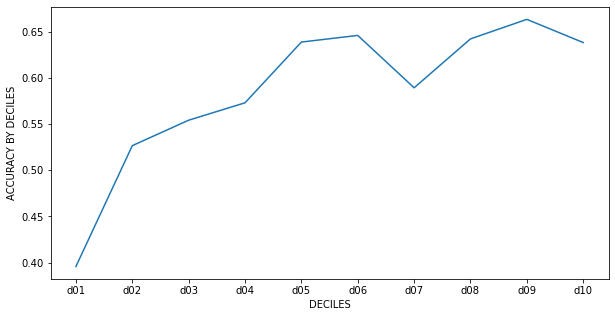

In [49]:
# plot distribution
fig = plt.figure(figsize = (10, 5))
plt.plot(acc_by_dec['y_true_disc'], acc_by_dec['falls_in_range'])
plt.xlabel("DECILES")
plt.ylabel("ACCURACY BY DECILES")
plt.show()

### Final Output

In [32]:
extra_features = ['car_id','match_v1_c','car_location_1']
data_output = pd.concat([df_scoreo_oot[extra_features].reset_index(drop=True)
                         ,X_oot.reset_index(drop=True)
                         ,pd.Series(y_oot,name='y_oot').reset_index(drop=True)
                         ,pd.Series(oot_pred,name='oot_pred')],1)
data_output

# faltaría sumarle una que indique el grupo de presencialidad (previo a eso re-entrenar sumando grupo 2 y 3 y ver como impacta en la perfo)

,car_id,match_v1_c,car_location_1,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,y_oot,oot_pred
0,1132553124,RS,Bs.As. G.B.A. Oeste,2021.00,6700,RENAULT,Sandero,II - 2.0 16v RS (145cv),Gama Pequenos Hatchback,Gama Pequenos,3600000,3187396.32
1,1133063732,1.6,Capital Federal,2021.00,18500,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3590000,3965111.74
2,1133503494,STEPWAY CONFORT 1.6 16V,Río Negro,2020.00,204000,RENAULT,Sandero Stepway,Fase II 1.6 16v Expression / Confort ABCP ABS ...,Gama Pequenos Hatchback,Gama Pequenos,1200000,2616370.00
3,1133724878,FELINE 1.6 TIPTRONIC AM20,Chubut,2013.00,130000,PEUGEOT,2008,1.6 16v. Feline Tiptronic (115cv) (L20),Suv Compactas 4x2,SUV,1300000,2100820.25
4,1125548551,ACTIVE 1.4 N 5P,Bs.As. G.B.A. Oeste,2013.00,126000,PEUGEOT,206,5Ptas. 1.4 Active / EdG Géneration,Gama Pequenos Hatchback,Gama Pequenos,1220000,1184659.46
...,...,...,...,...,...,...,...,...,...,...,...,...
18206,1130206778,1.6,Bs.As. G.B.A. Sur,2015.00,139000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1700000,1552828.83
18207,1129497150,1.6,Capital Federal,2015.00,148000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1500000,1528423.99
18208,1129453820,1.6,Bs.As. G.B.A. Oeste,2015.00,68000,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1750000,1744693.87
18209,1127541969,1.6,Bs.As. G.B.A. Oeste,2015.00,165170,VOLKSWAGEN,Voyage,1.6 Trendline / Comfortline (101cv) (MY14 ABG ...,Gama Pequenos Sedan,Gama Pequenos,1300000,1484531.02


In [33]:
# chequeo (tiene que mantenerse igual que el anterior) -- OK
print('OOT set evaluation:\n_____________________________________')
print_evaluate(data_output.y_oot, data_output.oot_pred)

OOT set evaluation:
_____________________________________
MAE: 162295.93690921937
MAPE: 7.426014964084057
MEDAPE: 5.698286291538135
MSE: 54043028826.101875
RMSE: 232471.56562922243
R2 Square 0.9733593177403232
__________________________________


---

To do list:

* 1) Hacer una validacion OOT pero usando unicamente IDs que NO hayan estado en el dataset de desarrollo.
* 2) Cranear un poco eso que pide pato de expandir la muestra extendiendo los días (ej usar 30 en lugar de 15) usando un delta de tiempo.
* 3) Empezar a abordar un modelo dolarizado.

### Anotaciones viejas pero quizas alguna sirve. Repasarlas y ver cuales rescatamos y cual borramos

VOLVER A CORRER LA NB DE TRAIN CON DATA NUEVA POR DOS MOTIVOS:
    1) POR LE VIENE BIEN AL ALGORTIMO PARA LA PREDICCION
    2) PORQUE SE CORRIGIO LO DEL AÑO 2008 Y HAY QUE SUMAR A LOS JSON QUE CONTIENEN LA INFO DE OUTLIERS POR CONTEXTO, LA INFO DE LOS 2008. PARA SALIR DEL PASO LE HICE UN "PARCHE" A FUNC_COTIZADOR.PY

* Revision del sheets: OK
    - ver si los autos que predecimos mal son siempre los mismos o aveces los predecimos bien.
    - revisar si en la simulacion estan metiendosé casos de versiones que no se usaron para train --> esto era así debido a que lo de los grupos lo había hecho a nivel marca-modelo, ahora le agregue el nivel de version y esto se tendría que coregir... esperemos a ver los resultados de las simul
* Ajustar procesamiento. OK
    * Hacer la limpieza de categorias a nivel marca-modelo-version, para excluir tanto del entrenamiento como de las simulaciones las versiones con bajo vol. (esto podría generar que la variable version pase a tener mayor importance) --> dicho y hecho, así fue.<br>
de la mano con esto, calcular que % de versiones estan quedando afuera en cada marca-modelo (o a nivel general, validarlo con Pato)
* Si no funciona lo del rango en base a kms hacerlo sobre el output directamente (usaremos un 10% dado que el MAPE es 9%)
* Accucary en base al rango.
* Ajustar procesamiento en la simulacion
* Hacer la matriz de confu que hice para airtm


* Backlog:
    * Hacer procsamiento de la version usando lo de (L11) que sería 2011, en ese caso fijarnos que eso coincida con el con car_year, y sino coincide eliminar el registro (ver el chat con Emi) y luego re-entrenar.
    * Re-entrenar con un nuevo make_data más actualizado y actualizando el tipo de cambio
    * Optimizar hiperparametros a ver si logramos mejorar el mape (hacerlo desde la nube rappi) -- si con grid search no mejoramos, probar optuna

Cotizador

- cambios en el entrenamiento para el v4

	- score matcheo >= 80  (POST SPLIT)
	- limpieza de categorías a nivel marca-modelo-version (POST SPLIT)
	- solo incluimos grupos 1, 2 y 3 para el algoritmo (PRE SPLIT)
	- usamos 3 en lugar de 1.5 para el tratamiento de outliers por contexto (POST SPLIT)

- faltaría sumar estas modificaciones en el processing en la simulacion

## Optimización de Hiperparametros

In [157]:
# # A)
# parameters = {'depth'         : [6,8,10],
#               'learning_rate' : [0.01, 0.05, 0.1, 0.15],
#               'iterations'    : [100, 120, 150, 200, 250],
#               'l2_leaf_reg': [0.2, 0.5, 1, 3]
#              }


# #model.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))

# model=CatBoostRegressor(loss_function='RMSE',logging_level="Silent")
# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 5, n_jobs= -1, scoring='r2')
# categorical_features_indices = np.where(X_train[model_features].dtypes != np.float)[0]
# grid.fit(X_train, y_train, cat_features=categorical_features_indices)#, eval_set=(X_test, y_test))    

# # Results from Grid Search
# print("\n========================================================")
# print(" Results from Grid Search " )
# print("========================================================")    

# print("\n The best estimator across ALL searched params:\n",
#       grid.best_estimator_)

# print("\n The best score across ALL searched params:\n",
#       grid.best_score_)

# print("\n The best parameters across ALL searched params:\n",
#       grid.best_params_)

# print("\n ========================================================")

Mediante la optimizacion de hiperparametros con GridSearch no mejoramos la performance. Tener en cuenta que el baseline de Catboost se caracteriza por ser bastante optimo. De todas formas más adelante podríamos probar Optuna a modo de mejora.

Por lo tanto, nuestro mejor modelo lo obtenemos con el baseline de CatBoost.

## Validacion OOT

In [55]:
# pending

Mejoras:
* Sumar la feature de discontinuados (Favio)
* Features de InfoAutos (Cande se esta encargando de eso pero todavía no las tenemos)
* Mejor preprocesing a la feature version (ej: standarizar los valores para los casos de nula volatilidad en el precio)